### 목차
#### 1. 고양이 수염을 붙이자.
#### 2. 다양한 이미지로 시도하자.
#### 3. 회고
***

##### 1. 고양이 수염을 붙이자.
- LMS의 순서에 따라 작성한 내용을 기능별로 함수로 정의하여 수정이 용이하게 하였다.
- location_img_sticker 함수에서 스티커가 __우측 또는 하단으로 벗어날 경우의 예외처리__ 도 추가하였다.
- 스티커가 더 자연스러운 위치에 오게하기위해 사용할 랜드마크와 위치 수치를 수정하였다.

In [49]:
# 고양이 수염을 적당한 위치에 붙이는 것까지 완성!
# 상기 코드를 함수화 하여 간결하고 수정이 용이하게하자.

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

#이미지 가져오는 함수
def get_image(path):    
    img_bgr = cv2.imread(path)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)     
    return img

#이미지 출력
def show_img(img):
    plt.imshow(img)
    plt.show()
    
#디텍터로 얼굴 사각형 찾기.
def detector_rect(img, pyramid = 1):
    detector_hog = dlib.get_frontal_face_detector()
    dlib_rects = detector_hog(img, pyramid)   # (image, num of image pyramid)
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        
        cv2.rectangle(img, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    print(dlib_rects)
        
    return img, dlib_rects

#
# 랜드마크 찾기
def get_landmarks(img, dlib_rects, model_path):
    landmark_predictor = dlib.shape_predictor(model_path)
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    #print('랜드마크 수 :',len(list_landmarks[0]))
    return list_landmarks

# 랜드마크 확인하기
def show_with_landmarks(img,list_landmarks):
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img, point, 2, (0, 255, 255), -1)
    return img



# 위치 x,y 잡기
def location_img_sticker(img, img_sticker, dlib_rects, list_landmarks):
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        #print (landmark[33]) # 코의 index는 30 입니다
        x = landmark[33][0]
        y = landmark[33][1] + dlib_rect.height()//2
        w = dlib_rect.width()
        h = dlib_rect.height()
        #print ('(x,y) : (%d,%d)'%(x,y))
        #print ('(w,h) : (%d,%d)'%(w,h))
    
    img_sticker = cv2.imread(sticker_path) 
    img_sticker = cv2.resize(img_sticker, (w,h)) # 크기 수정
    # x,y 는 스티커의 좌상단 이므로 조정한다.
    refined_x = x - w // 2
    refined_y = y - h
    #print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 스티커가 이미지밖으로 벗어난 경우, 음수로 표현된다고 한다.
# ndarray 는 음수 인덱스에 접근할 수 없기 때문에 예외 처리한다.

    if refined_x < 0: #왼쪽으로 벗어난 경우
        img_sticker = img_sticker[:, -refined_x:]
        print('왼쪽 벗어남')
        refined_x = 0
    if refined_y < 0: # 위로 벗어난경우
        img_sticker = img_sticker[-refined_y:, :]
        print('위로 벗어남')
        refined_y = 0
# 우측과 하단으로 벗어난 경우 추가.
    if refined_x + w > img.shape[1] : #오른쪽으로 벗어난 경우
        img_sticker = img_sticker[:, : img.shape[1] -refined_x]
        print('오른쪽으로 벗어남')
    if refined_y + h > img.shape[0]: #아래로 벗어난 경우
        img_sticker = img_sticker[img.shape[0] -refined_y:, :]
        print('아래로 벗어남')

    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
    return img_sticker, refined_x, refined_y
    
#np.where(condition, T, F) 값 변경
#img_show[from:to] 형식
def show_with_sticker(img,refined_x, refined_y):
    img_show = img.copy() # 출력용 이미지 가져오기.
    # 스티커 영역 = 이미지[수정y 에서 : 수정 y + 스티커의 세로길이],[수정x에서 : 수정 x + 스티커의 가로길이]                       
    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0],
                            refined_x:refined_x+img_sticker.shape[1]]
    # img_show 에 스티커 잘라 넣기/
    # 이미지의 스티커 영역 = np.where (스티커가 0(흑색) 이면, 스티커, (아니면) 스티커 이미지영역 )
    img_show[refined_y:refined_y+img_sticker.shape[0], 
             refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker == 0,img_sticker, sticker_area).astype(np.uint8) 
    plt.imshow(img_show)
    plt.show()

적용할 사진


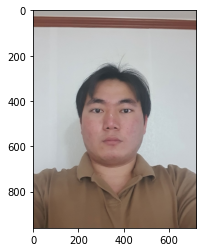

rectangles[[(200, 379) (468, 647)]]
얼굴 영역인식


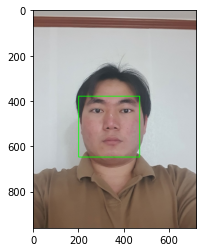

랜드마스크를 적용한 이미지


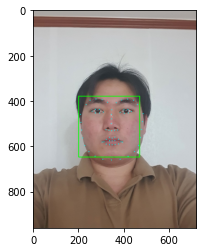

사용할 스티커


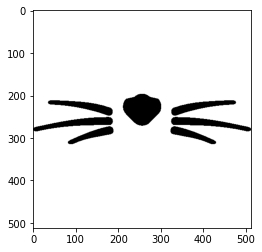

(x,y) : (211,396)
스티커를 적용한 이미지


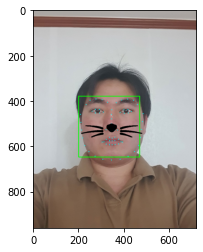

완성~


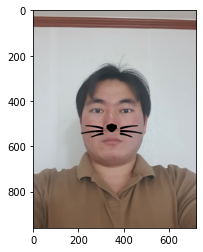

In [50]:
# 함수 작동 확인

#적용할 사진 가져오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/sticker_image/01.jpg'
img = get_image(my_image_path)
img_show = img.copy()
print('적용할 사진')
show_img(img)

img, dlib_rects = detector_rect(img)
print('얼굴 영역인식')
show_img(img)
#랜드마스크 모델 가져오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
list_landmarks = get_landmarks(img, dlib_rects, model_path)
print('랜드마스크를 적용한 이미지')
img = show_with_landmarks(img,list_landmarks)
show_img(img)

#스티커 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = get_image(sticker_path)
print('사용할 스티커')
show_img(img_sticker)
# 스티커 크기및 위치 조절.
img_sticker, refined_x, refined_y = location_img_sticker(img, img_sticker, dlib_rects, list_landmarks)
print('스티커를 적용한 이미지')
show_with_sticker(img,refined_x, refined_y)
print('완성~')
show_with_sticker(img_show,refined_x, refined_y)
#show_img(img)
#show_img(img_show)


##### 2. 다양한 이미지로 시도하자.

적용할 사진 : 오른쪽으로 잘린 사진


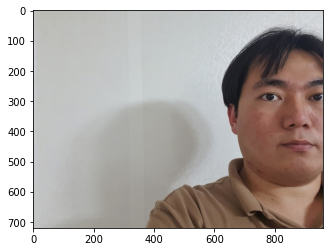

rectangles[[(705, 206) (1026, 527)]]
얼굴 영역인식


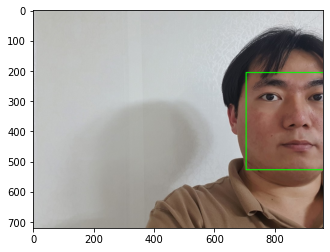

랜드마스크를 적용한 이미지


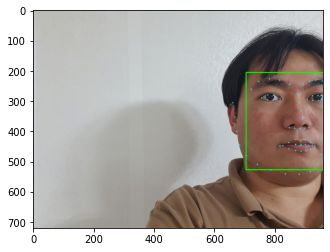

오른쪽으로 벗어남
(x,y) : (723,231)
스티커를 적용한 이미지


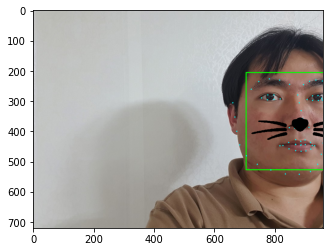

완성~


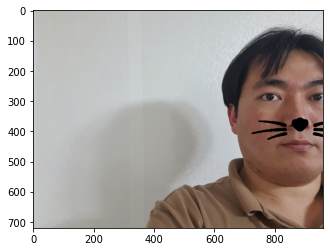

In [53]:
# 함수 작동 확인

#적용할 사진 가져오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/sticker_image/21.jpg'
img = get_image(my_image_path)
img_show = img.copy()
print('적용할 사진 : 오른쪽으로 잘린 사진')
show_img(img)

img, dlib_rects = detector_rect(img)
print('얼굴 영역인식')
show_img(img)
#랜드마스크 모델 가져오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
list_landmarks = get_landmarks(img, dlib_rects, model_path)
print('랜드마스크를 적용한 이미지')
img = show_with_landmarks(img,list_landmarks)
show_img(img)

#스티커 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = get_image(sticker_path)
#print('사용할 스티커')
#show_img(img_sticker)
# 스티커 크기및 위치 조절.
img_sticker, refined_x, refined_y = location_img_sticker(img, img_sticker, dlib_rects, list_landmarks)
print('스티커를 적용한 이미지')
show_with_sticker(img,refined_x, refined_y)
print('완성~')
show_with_sticker(img_show,refined_x, refined_y)
#show_img(img)
#show_img(img_show)

적용할 사진 : 아래로 잘린사진


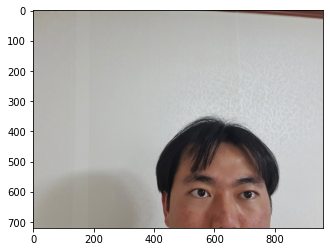

rectangles[]
얼굴 영역인식


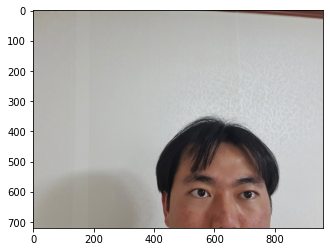

랜드마스크를 적용한 이미지


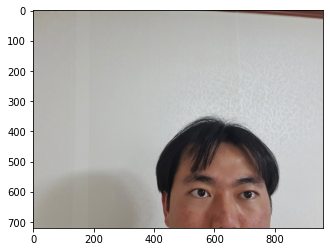

UnboundLocalError: local variable 'w' referenced before assignment

In [54]:
# 함수 작동 확인

#적용할 사진 가져오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/sticker_image/22.jpg'
img = get_image(my_image_path)
img_show = img.copy()
print('적용할 사진 : 아래로 잘린사진')
show_img(img)

img, dlib_rects = detector_rect(img)
print('얼굴 영역인식')
show_img(img)
#랜드마스크 모델 가져오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
list_landmarks = get_landmarks(img, dlib_rects, model_path)
print('랜드마스크를 적용한 이미지')
img = show_with_landmarks(img,list_landmarks)
show_img(img)

#스티커 가져오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = get_image(sticker_path)
#print('사용할 스티커')
#show_img(img_sticker)
# 스티커 크기및 위치 조절.
img_sticker, refined_x, refined_y = location_img_sticker(img, img_sticker, dlib_rects, list_landmarks)
print('스티커를 적용한 이미지')
show_with_sticker(img,refined_x, refined_y)
print('완성~')
show_with_sticker(img_show,refined_x, refined_y)
#show_img(img)
#show_img(img_show)

##### 다른 사진 결과
- 오른쪽으로 잘린 사진의 경우, 의도한 바와 같이 수정한 코드가 정상작동하여 이미지 바깥영역의 스티커를 잘라준다.
- 아래가 잘린 사진의 경우, 얼굴영역 부터 인식하지 못 한다.
- 잘린 부분이 많아 얼굴을 인식하지 못 한듯 하다. 당연히 얼굴영역을 인식하지 못 하면, 다음단계로 진행되지 않는다.

##### 3. 회고
- 어려웠던 점 : 오른쪽과 아래로 스티커가 벗어날 경우, 이를 판단할 조건문과 슬라이싱할 값을 새로 추가해주었다. 코드와 설명을 참고할 때, 조건문은 떠올리는 것은 쉬웠으나, 슬라이싱 구간은 생각하는 것은 쉽게 머리에서 그려지지 않았다. 노트에 직접 길이와 좌표를 그려 참고하여 추가된 슬라이싱 인덱스를 완성하였다.
- 시도한 것 : 고양이 수염이 자연스러운 위치에 올 수 있도록, 랜드마크의 값과 위치계산식을 수정하는 과정을 여러번 시도하여 최종 값을 얻었다. 또한 LMS에서 제기된 스티커가 오른쪽, 아래로 벗어날 경우 예외처리를 추가 하였고, 이를 예시 사진을 통해 확인하였다.
- 알게된 점 : 이미지가 많이 잘릴 경우 얼굴인식을 하지 못해, 이후 과정이 진행되지 못한다.
- 아쉬운 점 및 다짐
> - 복수의 얼굴이 있는 이미지에서 시도하지 못한 점이 아쉽다.
> - 다양한 얼굴의 각도에서 스티커를 적용하고, perspective transform 을 적용해 보고 싶었으나 하지 못해 아쉽다.
> - 익스노드 전받에 걸쳐 과제를 마감에 맞춰하다보니, 도전해볼 주제가 아쉬운 점으로만 남게된다. 좀더 일찍 시작하여 시간을 충분히 들일수 있도록 해야겠다.